In [1]:
from fastai.vision.all import *

In [2]:
PATH = Path('../input/optiver-realized-volatility-prediction')

# data_df = pd.read_parquet(PATH/'book_train_reindexed.parquet')

# sizes = ['bid_size1', 'bid_size2', 'ask_size1', 'ask_size2']
# for sz in sizes:
#     data_df[sz] = data_df[sz]/ 1_000_000



In [3]:
#train_df = pd.read_csv(PATH/'train_with_offset.csv')
# data_df['wap'] = (data_df.bid_price1 * data_df.ask_size1 + data_df.ask_price1 * data_df.bid_size1) / (data_df.ask_size1 + data_df.bid_size1)

# mean_wap =[]
# for row in train_df.itertuples():
#     df = data_df.iloc[row.offset:row.offset+600]
#     mean_wap.append(df.wap.mean())

In [13]:
# train_df['mean_wap']=mean_wap
# train_df.to_csv(PATH/'train_with_wap.csv')

In [11]:
# np_data = data_df[['bid_price1', 'ask_price1', 'bid_size1', 'ask_size1','bid_price2', 'ask_price2', 'bid_size2', 'ask_size2']].to_numpy()

# del data_df

# np_data = np_data.astype('float32')
# torch_data = torch.tensor(np_data)

# del np_data

# torch.save(torch_data, PATH/'torch_data.pth')

In [3]:
%%time
torch_data = torch.load(PATH/'torch_data.pth')

CPU times: user 0 ns, sys: 1.96 s, total: 1.96 s
Wall time: 1.96 s


In [4]:
train_df = pd.read_csv(PATH/'train_with_wap.csv')

In [5]:
w = train_df.mean_wap.to_numpy()

w =np.sort(w)

bins = []

step = (len(w)+9)//10
for i in range(0, len(w), step):
    j = min(i+step, len(w))
    bins.append(w[j] if j< len(w) else 2)
    print(w[i], w[j-1],np.median(w[i:j]) )

wap_bin = np.digitize(train_df.mean_wap, bins)

train_df['wap_bin']=wap_bin

0.9172531180048944 0.9971951138775056 0.9956492523836432
0.9971951327900604 0.9984703256953886 0.9979708959569917
0.9984703751656142 0.9991431543863876 0.9988451162091514
0.9991431683337992 0.999616836138266 0.9993924853218963
0.9996168497680276 1.0000141933324718 0.9998199779860442
1.0000141975255898 1.0004091980748968 1.00020793857736
1.0004091986325243 1.000876884050013 1.0006291062379966
1.0008769297217603 1.0015230362748495 1.0011664016312456
1.0015230933064834 1.002768629281105 1.0020189286622183
1.0027686365447124 1.077264872305151 1.004330146304397


In [6]:
w = train_df.target.to_numpy()

w =np.sort(w)

bins = []
bin_med=[]
step = (len(w)+9)//10
for i in range(0, len(w), step):
    j = min(i+step, len(w))
    bins.append(w[j] if j< len(w) else 1)
    bin_med.append(np.median(w[i:j]))
    print(w[i], w[j-1],np.median(w[i:j]) )

target_bin = np.digitize(train_df.target, bins)

train_df['target_bin']=target_bin

0.000105263 0.001436988 0.001175852
0.001436991 0.001838282 0.0016455530000000001
0.001838308 0.002210492 0.0020263215
0.002210493 0.002604845 0.00240206
0.002604847 0.003048064 0.002817908
0.003048071 0.003585089 0.0033027735
0.003585105 0.00428704 0.003905317
0.004287042 0.005311553 0.0047378975
0.005311559 0.007240946 0.0060829544999999995
0.007240976 0.07032062 0.009453786499999998


In [23]:
class Conv8(nn.Module):
    def __init__(self, ch_in, ch_out):
        super().__init__()
        self.conv = nn.Conv2d(ch_in, ch_out * 8, kernel_size=(3,8), padding=(1,0))
        self.bn = nn.BatchNorm2d(ch_out)
        
    def forward(self, x):
        x = self.conv(x)
        ch = x.shape[1]
        step = ch // 8
        parts = [x[:,i:i+step,:,:] for i in range(0, ch, step)]
        res = torch.cat(parts, dim=3)
        res = self.bn(res)
        #res = F.dropout(res)
        res = F.relu(res)
        return res

class ConvModel(nn.Module):
    def __init__(self, num_outputs=1):
        super().__init__()
        #sizes = [1,8,8,16,16,32,32,64,64]
        #sizes = [1,2,4,8,16,32,64,128,256]
        sizes = [1,16,16,32,32,64,64,128,128]
        mp = nn.MaxPool2d(kernel_size = (2,1))
        layers = []
        for c_in, c_out in zip(sizes, sizes[1:]):
            layers.append(Conv8(c_in, c_out))
            layers.append(mp)
        layers.append(Flatten())
        layers.append(nn.Dropout())
        layers.append(nn.Linear(2*8*sizes[-1], num_outputs))
        #layers.append(SigmoidRange(0,1))
        self.layers = nn.Sequential(*layers)
    def forward(self, x):
        return self.layers(x)
        

In [24]:
class ResBlock(nn.Module):
    def __init__(self, ch):
        super().__init__()
        self.conv1 = Conv8(ch, ch)
        self.conv2 = Conv8(ch, ch)
    def forward(self, x):
        res = self.conv1(x)
        res = self.conv2(res)
        res += x
        res = F.relu(res)
        return res

In [47]:
class ResnetModel(nn.Module):
    def __init__(self, num_outputs):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(1,32, (1,1)),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            ResBlock(32),
            #ResBlock(64),
            nn.AvgPool2d((2,1)),
            nn.Conv2d(32,64, (1,1)),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            ResBlock(64),
            #ResBlock(128),
            nn.AvgPool2d((2,1)),
            ResBlock(64),
            #ResBlock(128),
            nn.AvgPool2d((2,1)),
            ResBlock(64),
            #ResBlock(128),
            nn.AvgPool2d((2,1)),
            ResBlock(64),
            #ResBlock(128),
            nn.AvgPool2d((2,1)),
            ResBlock(64),
            #ResBlock(128),
            nn.AvgPool2d((2,1)),
            ResBlock(64),
           # ResBlock(128),
            Flatten(),
            nn.Dropout(),
            nn.Linear(4608, num_outputs)
        )
    def forward(self, x):
        return self.layers(x)

In [37]:
class LoadTransform(Transform):
    def __init__(self, torch_data):
        super().__init__()
        self.data = torch_data
        
    def encodes(self, row):
        #df = self.data.iloc[row.offset:row.offset+600]
        #ret = df[['bid_price1', 'ask_price1', 'bid_size1', 'ask_size1','bid_price2', 'ask_price2', 'bid_size2', 'ask_size2']].to_numpy()
        #ret = ret.reshape(1,600,8).astype('float32')
        ret = self.data[row.offset:row.offset+600]
        return ret.view(1,600,8)

tfm = LoadTransform(torch_data)

data_block = DataBlock(
        blocks = (TransformBlock(type_tfms=tfm), 
                  #RegressionBlock()),
                  CategoryBlock(vocab=list(range(10)))),
        splitter=ColSplitter(),
        #get_y=ColReader('target'),
        #get_y=ColReader('wap_bin'),
        get_y=ColReader('target_bin'),
)
dls = data_block.dataloaders(train_df, bs=128)

In [48]:
bx,by = dls.one_batch()

In [49]:
ResnetModel(10).cuda()(bx).shape

torch.Size([128, 10])

In [50]:
def rmspe(preds, targs):
    x = (targs-preds)/targs
    return (x**2).mean().sqrt()

In [51]:
def mspe_loss(preds, targs):
    x = (targs-preds)/targs
    return (x**2).mean()

In [52]:
def rmspe_loss(preds, targs):
    x = (targs-preds)/targs
    return (x**2).mean().sqrt()

In [53]:
#learn = Learner(dls, ConvModel(),loss_func=mspe_loss, metrics=AccumMetric(rmspe))
learn = Learner(dls, ResnetModel(10), metrics = [accuracy])

SuggestedLRs(lr_min=3.311311302240938e-05, lr_steep=3.981071586167673e-06)

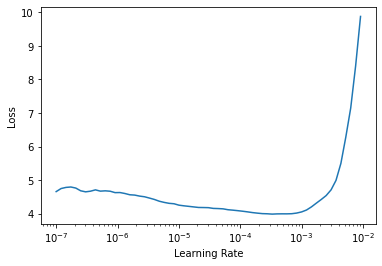

In [54]:
learn.lr_find()

In [55]:
learn.fit_one_cycle(12,1e-4, wd=.2)

epoch,train_loss,valid_loss,accuracy,time
0,2.377702,3.409854,0.131178,06:48
1,1.946433,2.836054,0.151927,06:48
2,1.897018,12.441448,0.098000,06:49
3,1.778752,3.650270,0.128409,06:49
4,1.704339,14.490758,0.099256,06:48
5,1.681896,2.520301,0.117224,06:49
6,1.600642,6.696712,0.105831,06:49
7,1.600740,6.229777,0.105343,06:50
8,1.572951,2.630081,0.174604,06:48
9,1.575535,1.597632,0.351208,06:42


In [56]:
learn.save('res_model1.pth')

Path('models/res_model1.pth.pth')

In [57]:
learn.fit_one_cycle(12,1e-5, wd=.2)

epoch,train_loss,valid_loss,accuracy,time
0,1.550813,1.838840,0.279019,06:40
1,1.552859,1.552302,0.364003,06:40
2,1.559559,1.987477,0.268639,06:41
3,1.550203,2.279363,0.233215,06:40
4,1.543883,1.830157,0.284350,06:40
5,1.549478,2.768147,0.189949,06:40
6,1.541609,1.552478,0.364589,06:40
7,1.543018,2.180596,0.241620,06:41
8,1.530661,2.036556,0.263503,06:40
9,1.536412,1.539069,0.372505,06:40


In [58]:
learn.save('res_model2.pth')

Path('models/res_model2.pth.pth')

In [161]:
learn.fit_one_cycle(12,1e-4, wd=.2)

epoch,train_loss,valid_loss,accuracy,time
0,1.597209,2.077627,0.228922,01:20
1,1.609287,1.729885,0.296658,01:20
2,1.617028,1.950104,0.252964,01:21
3,1.602081,3.000583,0.173920,01:21
4,1.606294,2.774225,0.174787,01:19
5,1.600084,2.167487,0.247243,01:19
6,1.590643,1.688386,0.333520,01:19
7,1.590177,1.895393,0.266870,01:19
8,1.589354,2.055529,0.243291,01:20
9,1.572543,1.605879,0.350573,01:19


In [169]:
learn.fit_one_cycle(20,1e-4, wd=.2)

epoch,train_loss,valid_loss,accuracy,time
0,1.578581,1.567301,0.360722,01:20
1,1.584059,3.701735,0.133533,01:21
2,1.584336,1.606512,0.348805,01:21
3,1.595317,3.025112,0.163223,01:21
4,1.591235,1.813334,0.264577,01:19
5,1.584900,2.440204,0.226738,01:19
6,1.594958,3.140395,0.177324,01:22
7,1.585306,2.687588,0.199000,01:21
8,1.586845,1.723637,0.298365,01:21
9,1.579450,2.046695,0.277116,01:21


In [59]:
preds, targs = learn.get_preds()

In [60]:
predicted_bins = torch.argmax(preds, dim=1)

In [172]:
CI = ClassificationInterpretation.from_learner(learn)

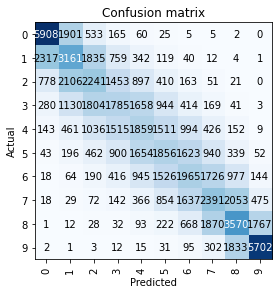

In [173]:
CI.plot_confusion_matrix()

In [61]:
pred_vals =torch.tensor(bin_med)[predicted_bins]

In [69]:
target_vals = dls.valid.items.target.to_numpy()
target_vals = torch.tensor(target_vals)

In [70]:
pred_vals[:10], target_vals[:10]

(tensor([0.0047, 0.0020, 0.0024, 0.0024, 0.0047, 0.0033, 0.0024, 0.0095, 0.0047,
         0.0061], dtype=torch.float64),
 tensor([0.0037, 0.0018, 0.0021, 0.0021, 0.0040, 0.0032, 0.0030, 0.0135, 0.0037,
         0.0054], dtype=torch.float64))

In [71]:
rmspe(pred_vals, target_vals)

tensor(0.3386, dtype=torch.float64)